In [1]:
import cv2
import numpy as np
import time
import pickle
import math
import pandas as pd

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
CLASSES = ['palm', 'left', 'right',  'up', 'down', 'palm_l', 'palm_r', 'palm_u', 'fist', 'hook', 'stop', 'thumb_in']

def angle(v1, v2):
  unit_v1 = v1 / np.linalg.norm(v1)
  unit_v2 = v2 / np.linalg.norm(v2)
  dot_product = np.dot(unit_v1, unit_v2)
  angle = np.arccos(dot_product)
  return angle

def distance(x1, x2):
  return math.sqrt((x1[0] - x2[0])**2 + (x1[1] - x2[1])**2 + (x1[2] - x2[2])**2)


def feature_extraction(X, allow_distance=False, allow_palm_angles=False, allow_fingertip_angles=False, allow_fingerbone_angles=False):
    yaw, pitch, roll, handedness = X[-4:]
    raw_skeleton = X[:-4]
    features = []

    # perform feature extraction
    joints = raw_skeleton.reshape(-1,3)

    # palm joint
    palm = joints[0]
    # thumb joints
    thumb = joints[1:6]
    thumb_bones = [thumb[i+1]-thumb[i] for i in range(1,4)]
    # index joints
    index = joints[6:11]
    index_bones = [index[i+1]-index[i] for i in range(0,4)]
    # middle joints
    middle = joints[11:16]
    middle_bones = [middle[i+1]-middle[i] for i in range(0,4)]
    # ring joints
    ring = joints[16:21]
    ring_bones = [ring[i+1]-ring[i] for i in range(0,4)]
    # pinky joints
    pinky = joints[21:26]
    pinky_bones = [pinky[i+1]-pinky[i] for i in range(0,4)]
    # fingertip joints
    fingertip_joints = np.array([thumb[-1], index[-1], middle[-1], ring[-1], pinky[-1]])

    # angles between finger bones
    if allow_fingerbone_angles:
      thumb_angles = np.array([angle(thumb_bones[i], thumb_bones[i+1]) for i in range(0,2)])
      index_angles = np.array([angle(index_bones[i], index_bones[i+1]) for i in range(0,3)])
      middle_angles = np.array([angle(middle_bones[i], middle_bones[i+1]) for i in range(0,3)])
      ring_angles = np.array([angle(ring_bones[i], ring_bones[i+1]) for i in range(0,3)])
      pinky_angles = np.array([angle(pinky_bones[i], pinky_bones[i+1]) for i in range(0,3)])
      fingerbone_angles = np.concatenate((thumb_angles, index_angles, middle_angles, ring_angles, pinky_angles))
      features.append(fingerbone_angles)

    # angles between fingertips
    if allow_fingertip_angles:
      fingertip_vectors = fingertip_joints - palm
      fingertip_angles = np.array([angle(fingertip_vectors[i], fingertip_vectors[i+1]) for i in range(0,4)])
      features.append(fingertip_angles)

    # yaw pitch roll angle of palm
    if allow_palm_angles:
      palm_angles = np.array([yaw, pitch, roll])
      features.append(palm_angles)

    # pairwise distance
#     if self.scaler is not None:
#       fingertip_palm_distances = np.array([distance(palm, x) for x in fingertip_joints])
#       fingertip_distances = np.array([distance(fingertip_joints[i], fingertip_joints[i+1]) for i in range(0,4)])
#       pairwise_distances = np.concatenate((fingertip_palm_distances, fingertip_distances))
#       scaled_distances = self.scaler.transform(pairwise_distances.reshape(1,-1))[0]
#       features.append(scaled_distances)

    if allow_distance:
      fingertip_palm_distances = np.array([distance(palm, x) for x in fingertip_joints])
      fingertip_distances = np.array([distance(fingertip_joints[i], fingertip_joints[i+1]) for i in range(0,4)])
      pairwise_distances = np.concatenate((fingertip_palm_distances, fingertip_distances))
      features.append(pairwise_distances)

    if len(features) == 0:
      feature_vector =  np.array(raw_skeleton)
    elif len(features) == 1:
      feature_vector =  features[0]
    else:
      feature_vector = np.concatenate(features, axis=0)

    return feature_vector

Load dataset

In [3]:
data_train_path = 'D:\\bachkhoa\\bachkhoa222\\Luan van\\LeapMotionHGR\\data_collection\\array_data\\pose_data_train_v5.pkl'
with open(data_train_path, 'rb') as f:
  data_train = pickle.load(f)

data_test_path = 'D:\\bachkhoa\\bachkhoa222\\Luan van\\LeapMotionHGR\\data_collection\\array_data\\pose_data_test_v5.pkl'
with open(data_test_path, 'rb') as f:
  data_test = pickle.load(f)

data_train_X, data_train_y = [], []
train_path, test_path = [], []
for X, y, path in data_train:
  data_train_X.append(np.array(X))
  data_train_y.append(y)
  train_path.append(path)

data_test_X, data_test_y = [], []
for X, y, path in data_test:
  data_test_X.append(np.array(X))
  data_test_y.append(y)
  test_path.append(path)

In [4]:
# Preprocess data
def preprocess_data(data_train_X, data_train_y, data_test_X, data_test_y, **kwargs):
#   scaler = None
#   if allow_scale:
#     scaler = StandardScaler()
#     distances = []
#     for X in data_train_X:
#       joints = X[:-4].reshape(-1,3)
#       palm = joints[0]
#       fingertip_joints = joints[[5,10,15,20,25]]
#       fingertip_palm_distances = np.array([distance(palm, x) for x in fingertip_joints])
#       fingertip_distances = np.array([distance(fingertip_joints[i], fingertip_joints[i+1]) for i in range(0,4)])
#       pairwise_distances = np.concatenate((fingertip_palm_distances, fingertip_distances))
#       distances.append(pairwise_distances)
#     scaler.fit(np.array(distances))
  
  X_train = np.array([feature_extraction(X, **kwargs) for X in data_train_X])
  y_train = np.array(data_train_y)
  X_test = np.array([feature_extraction(X, **kwargs) for X in data_test_X])
  y_test = np.array(data_test_y)

  scaler = StandardScaler()
  X_train = scaler.fit_transform(X_train)
  X_test = scaler.transform(X_test)
    
  return X_train, y_train, X_test, y_test, scaler

In [5]:
X_train, y_train, X_test, y_test, scaler = preprocess_data(data_train_X, data_train_y, data_test_X, data_test_y, allow_distance=True, allow_palm_angles=True, allow_fingertip_angles=True, allow_fingerbone_angles=False)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4396, 16), (1928, 16), (4396,), (1928,))

Training and evaluating the model

In [14]:
def evaluate(model, X_test, y_test):
  y_pred = model.predict(X_test)
  acc = accuracy_score(y_test, y_pred)
  print(f"Model accuracy is: {acc}")
  print(classification_report(y_test, y_pred, target_names=CLASSES, digits=4))
  # Calculate inference time: including feature extraction and model inference
  start = time.perf_counter()
  model.predict(X_train[0].reshape(1,-1))
  elapse_s = (time.perf_counter() - start)*1000
  print(f"Model elapse time is: {elapse_s}s")

  # confusion matrix
  cf_matrix = confusion_matrix(y_test, y_pred)
  cf_matrix_norm = np.around(cf_matrix / cf_matrix.sum(axis=1)[:,None], 2)
  sns.set(font_scale=1.5)
  sns.set(rc={"figure.figsize":(15, 12)})
  ax = sns.heatmap(cf_matrix_norm, annot=True, cmap='Blues')
  ax.set_title(f'Confusion matrix', fontsize=20)
  ax.set_xlabel('\nPredicted Values', fontsize=20)
  ax.set_ylabel('Actual Values', fontsize=20)
  
  ax.xaxis.set_ticklabels(CLASSES, fontsize=15)
  ax.yaxis.set_ticklabels(CLASSES, fontsize=15)
  plt.savefig("D:\\bachkhoa\\bachkhoa222\\Luan van\\images\\training_result\\svm_cf_matrix.pdf", format="pdf", bbox_inches="tight")
  plt.show()

SVM

Model accuracy is: 0.9683609958506224
              precision    recall  f1-score   support

        palm     0.9130    0.9492    0.9307       177
        left     0.9218    0.9593    0.9402       172
       right     1.0000    0.9722    0.9859       180
          up     0.9939    0.9760    0.9849       167
        down     0.9803    0.8922    0.9342       167
      palm_l     0.9044    1.0000    0.9498       123
      palm_r     0.9916    1.0000    0.9958       118
      palm_u     1.0000    0.9060    0.9507       149
        fist     1.0000    0.9897    0.9948       194
        hook     0.9867    0.9867    0.9867       150
        stop     0.9321    1.0000    0.9649       151
    thumb_in     1.0000    1.0000    1.0000       180

    accuracy                         0.9684      1928
   macro avg     0.9686    0.9693    0.9682      1928
weighted avg     0.9698    0.9684    0.9684      1928

Model elapse time is: 0.3654999999866959s


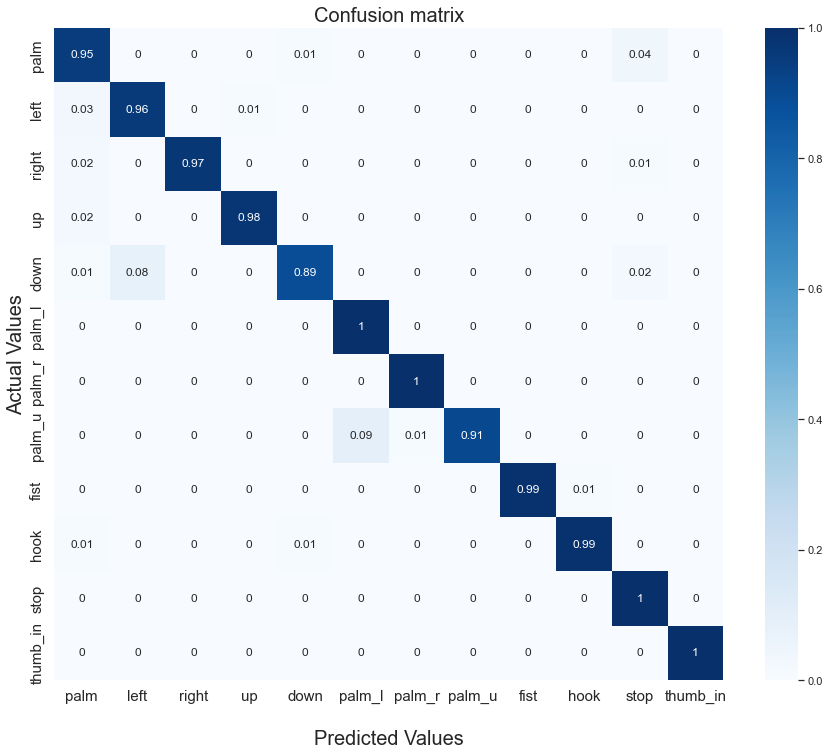

In [15]:
with open('D:\\bachkhoa\\bachkhoa222\\Luan van\\LeapMotionHGR\\model\\weights\\SVC_weights_0805.pkl', 'rb') as f:
  svc = pickle.load(f)
evaluate(svc, X_test, y_test)

0.9770040381031269
{'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}
Model accuracy is: 0.9683609958506224
              precision    recall  f1-score   support

        palm     0.9130    0.9492    0.9307       177
        left     0.9218    0.9593    0.9402       172
       right     1.0000    0.9722    0.9859       180
          up     0.9939    0.9760    0.9849       167
        down     0.9803    0.8922    0.9342       167
      palm_l     0.9044    1.0000    0.9498       123
      palm_r     0.9916    1.0000    0.9958       118
      palm_u     1.0000    0.9060    0.9507       149
        fist     1.0000    0.9897    0.9948       194
        hook     0.9867    0.9867    0.9867       150
        stop     0.9321    1.0000    0.9649       151
    thumb_in     1.0000    1.0000    1.0000       180

    accuracy                         0.9684      1928
   macro avg     0.9686    0.9693    0.9682      1928
weighted avg     0.9698    0.9684    0.9684      1928

Model elapse time is: 0.415399999

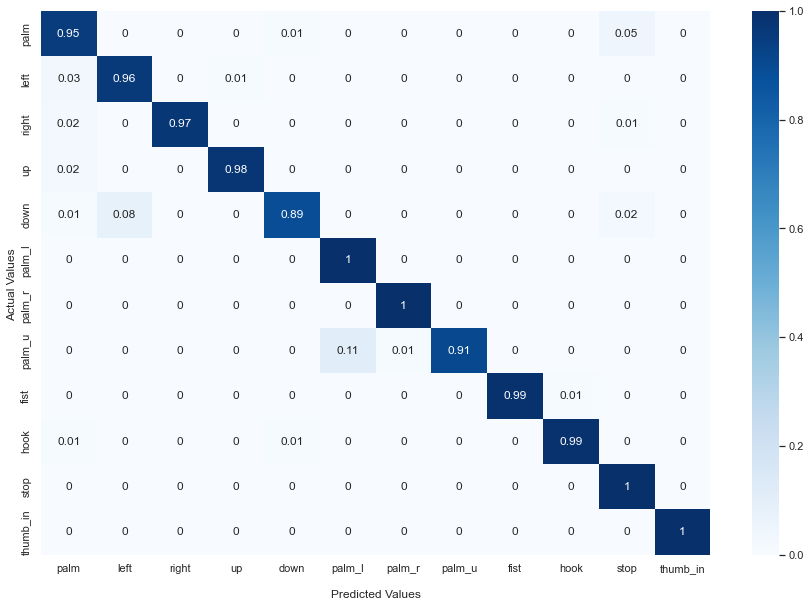

In [94]:
#parameter tuning
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
# perform grid search
svc_param = {'C': [0.1,1,10,100], 'gamma': [0.1,0.01,0.001],'kernel': ['rbf', 'sigmoid'], 'probability': [True]}
grid_svc = GridSearchCV(SVC(probability=True), svc_param, refit=True, verbose=1, cv=10)
grid_svc.fit(X_train,y_train)
print(grid_svc.best_score_)
print(grid_svc.best_params_)
svc = grid_svc.best_estimator_
evaluate(svc, X_test, y_test)

Model accuracy is: 0.9683609958506224
              precision    recall  f1-score   support

        palm     0.9130    0.9492    0.9307       177
        left     0.9218    0.9593    0.9402       172
       right     1.0000    0.9722    0.9859       180
          up     0.9939    0.9760    0.9849       167
        down     0.9803    0.8922    0.9342       167
      palm_l     0.9044    1.0000    0.9498       123
      palm_r     0.9916    1.0000    0.9958       118
      palm_u     1.0000    0.9060    0.9507       149
        fist     1.0000    0.9897    0.9948       194
        hook     0.9867    0.9867    0.9867       150
        stop     0.9321    1.0000    0.9649       151
    thumb_in     1.0000    1.0000    1.0000       180

    accuracy                         0.9684      1928
   macro avg     0.9686    0.9693    0.9682      1928
weighted avg     0.9698    0.9684    0.9684      1928

Model elapse time is: 0.669599998218473s


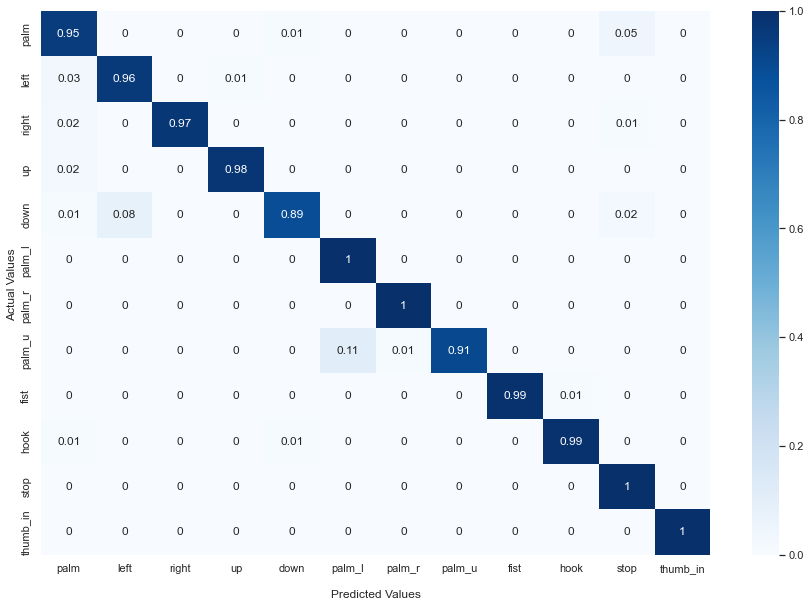

In [105]:
svc = SVC(C=100, kernel='rbf', gamma=0.01, probability=True)
svc.fit(X_train, y_train)
evaluate(svc, X_test, y_test)

Logistic Regression

Fitting 10 folds for each of 5 candidates, totalling 50 fits


D:\miniconda\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
D:\miniconda\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_resu

0.8669025678194243
{'C': 1.0, 'max_iter': 500, 'penalty': 'l2'}
Model accuracy is: 0.8220954356846473
              precision    recall  f1-score   support

        palm     0.7899    0.5311    0.6351       177
        left     0.9461    0.9186    0.9322       172
       right     0.9880    0.9167    0.9510       180
          up     1.0000    0.9940    0.9970       167
        down     0.9932    0.8802    0.9333       167
      palm_l     0.6032    0.6179    0.6104       123
      palm_r     0.6250    0.9322    0.7483       118
      palm_u     0.1871    0.1745    0.1806       149
        fist     1.0000    0.9897    0.9948       194
        hook     0.9930    0.9467    0.9693       150
        stop     0.6791    0.9669    0.7978       151
    thumb_in     0.9588    0.9056    0.9314       180

    accuracy                         0.8221      1928
   macro avg     0.8136    0.8145    0.8068      1928
weighted avg     0.8336    0.8221    0.8211      1928

Model elapse time is: 0.3608999

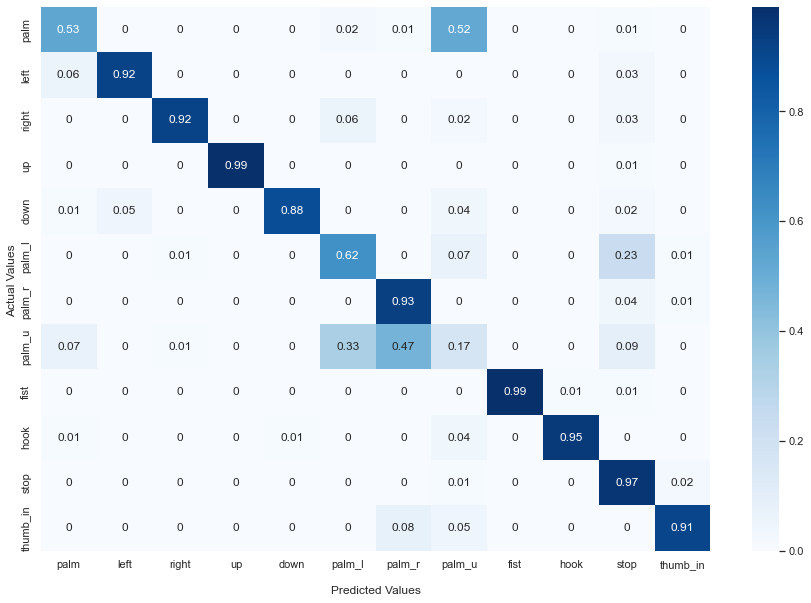

In [98]:
from sklearn.linear_model import LogisticRegression
# perform grid search
lr_param = {'C': np.logspace(-2,2,5), 'penalty':['l2'], 'max_iter': [500]} #l1: lasso, l2: ridge
grid_lr = GridSearchCV(LogisticRegression(), lr_param, refit=True, verbose=1, cv=10)
grid_lr.fit(X_train,y_train)
print(grid_lr.best_score_)
print(grid_lr.best_params_)
lr = grid_lr.best_estimator_
evaluate(lr, X_test, y_test)

Random Forest

Fitting 10 folds for each of 32 candidates, totalling 320 fits
0.9615406916545869
{'criterion': 'gini', 'max_depth': 8, 'max_features': 'log2', 'n_estimators': 200}
Model accuracy is: 0.9133817427385892
              precision    recall  f1-score   support

        palm     0.6654    0.9774    0.7918       177
        left     0.9828    0.9942    0.9884       172
       right     0.9649    0.9167    0.9402       180
          up     1.0000    0.9401    0.9691       167
        down     0.9936    0.9281    0.9598       167
      palm_l     0.7778    0.9106    0.8390       123
      palm_r     0.9672    1.0000    0.9833       118
      palm_u     1.0000    0.7517    0.8582       149
        fist     1.0000    0.9897    0.9948       194
        hook     0.9524    0.9333    0.9428       150
        stop     0.8683    0.9603    0.9119       151
    thumb_in     0.9603    0.6722    0.7908       180

    accuracy                         0.9134      1928
   macro avg     0.9277    0.9145    0.

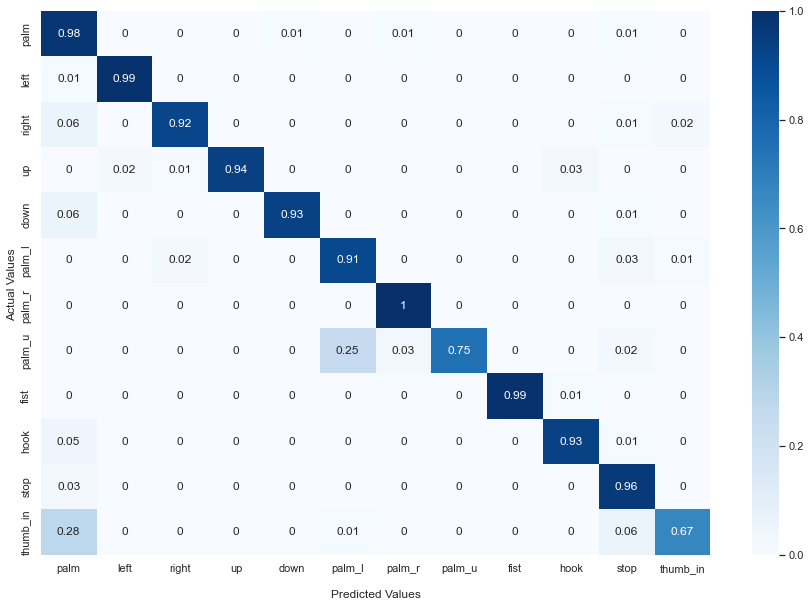

In [118]:
from sklearn.ensemble import RandomForestClassifier
rf_param = { 
    'n_estimators': [100, 200],
    'max_features': ['sqrt', 'log2'],
    'max_depth' : [5,6,7,8],
    'criterion' :['gini', 'entropy']
}
grid_rf = GridSearchCV(RandomForestClassifier(), rf_param, refit=True, verbose=4, n_jobs=-1, cv=10)
grid_rf.fit(X_train,y_train)
print(grid_rf.best_score_)
print(grid_rf.best_params_)
rf = grid_rf.best_estimator_
evaluate(rf, X_test, y_test)

Fitting 10 folds for each of 24 candidates, totalling 240 fits


D:\miniconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


0.9715375854214123
{'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': (100,), 'learning_rate': 'adaptive', 'solver': 'adam'}
Model accuracy is: 0.9673236514522822
              precision    recall  f1-score   support

        palm     0.9130    0.9492    0.9307       177
        left     0.9405    0.9186    0.9294       172
       right     1.0000    0.9389    0.9685       180
          up     1.0000    0.9940    0.9970       167
        down     0.9873    0.9281    0.9568       167
      palm_l     0.9370    0.9675    0.9520       123
      palm_r     0.9833    1.0000    0.9916       118
      palm_u     1.0000    0.9799    0.9898       149
        fist     1.0000    0.9691    0.9843       194
        hook     0.9545    0.9800    0.9671       150
        stop     0.8988    1.0000    0.9467       151
    thumb_in     0.9945    1.0000    0.9972       180

    accuracy                         0.9673      1928
   macro avg     0.9674    0.9688    0.9676      1928
weighted avg   

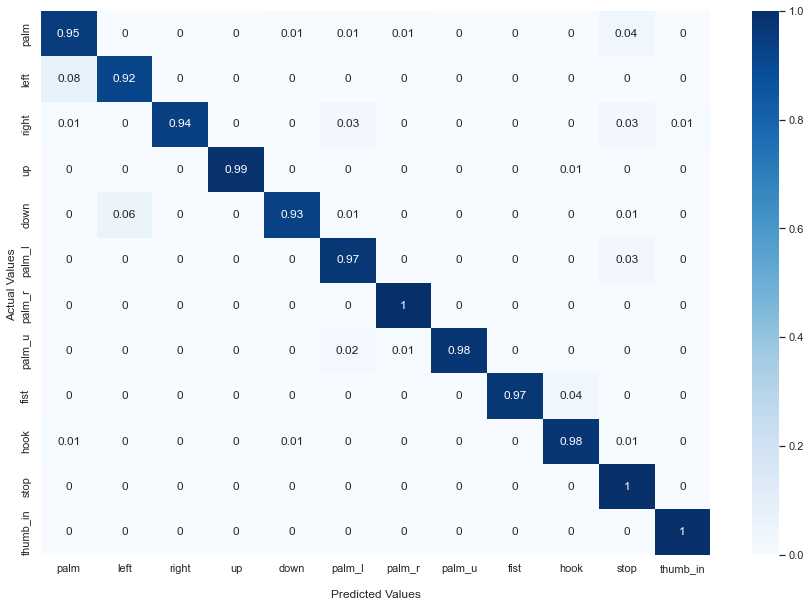

In [122]:
# MLP
from sklearn.neural_network import MLPClassifier
mlp_param = {
    'hidden_layer_sizes': [(100,), (50,100)],
    'activation': ['relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.001, 0.01], # regularization term
    'learning_rate': ['constant','adaptive'],
}
grid_mlp = GridSearchCV(MLPClassifier(max_iter=200), mlp_param, n_jobs=-1, refit=True, cv=10, verbose=2)
grid_mlp.fit(X_train,y_train)
print(grid_mlp.best_score_)
print(grid_mlp.best_params_)
mlp = grid_mlp.best_estimator_
evaluate(mlp, X_test, y_test)

Fitting 10 folds for each of 28 candidates, totalling 280 fits
0.9599368399254503
{'n_neighbors': 3}
Model accuracy is: 0.9221991701244814
              precision    recall  f1-score   support

        palm     0.7727    0.8644    0.8160       177
        left     0.9217    0.8895    0.9053       172
       right     1.0000    0.9444    0.9714       180
          up     0.9695    0.9521    0.9607       167
        down     0.9620    0.9102    0.9354       167
      palm_l     0.7202    0.9837    0.8316       123
      palm_r     0.9360    0.9915    0.9630       118
      palm_u     1.0000    0.6577    0.7935       149
        fist     1.0000    0.9897    0.9948       194
        hook     0.9866    0.9800    0.9833       150
        stop     0.8580    0.9603    0.9063       151
    thumb_in     1.0000    0.9500    0.9744       180

    accuracy                         0.9222      1928
   macro avg     0.9272    0.9228    0.9196      1928
weighted avg     0.9323    0.9222    0.9225      

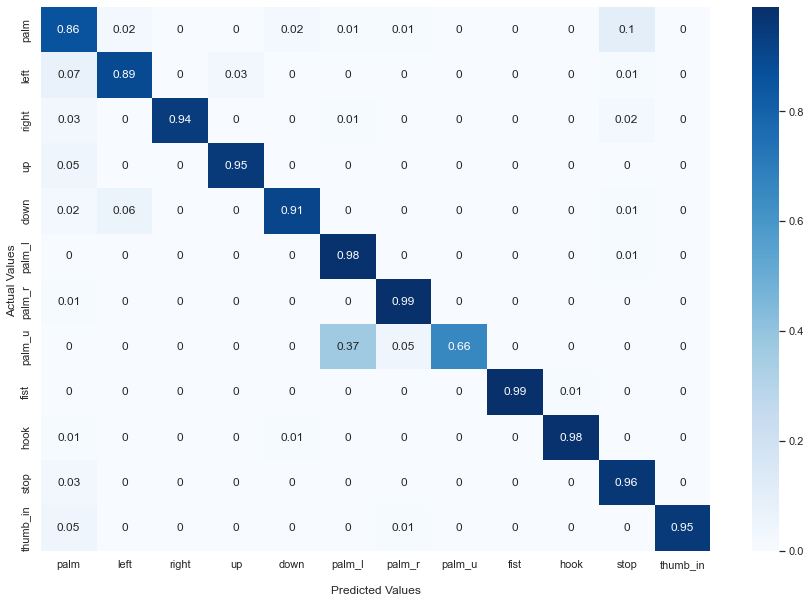

In [115]:
# kNN
from sklearn.neighbors import KNeighborsClassifier
knn_param = {
    'n_neighbors': list(range(2,30)),
}
grid_knn = GridSearchCV(KNeighborsClassifier(n_jobs=-1), knn_param, n_jobs=-1, refit=True, verbose=2, cv=10)
grid_knn.fit(X_train,y_train)
print(grid_knn.best_score_)
print(grid_knn.best_params_)
knn = grid_knn.best_estimator_
evaluate(knn, X_test, y_test)

In [123]:
import pickle
# with open('D:\\bachkhoa\\bachkhoa222\\Luan van\\LeapMotionHGR\\model\\weights\\SVC_weights_0805.pkl', 'wb') as f:
#   pickle.dump(svc, f)
# with open('D:\\bachkhoa\\bachkhoa222\\Luan van\\LeapMotionHGR\\model\\weights\\LR_weights_0805.pkl', 'wb') as f:
#   pickle.dump(lr, f)
with open('D:\\bachkhoa\\bachkhoa222\\Luan van\\LeapMotionHGR\\model\\weights\\RF_weights_0805.pkl', 'wb') as f:
  pickle.dump(rf, f)
with open('D:\\bachkhoa\\bachkhoa222\\Luan van\\LeapMotionHGR\\model\\weights\\kNN_weights_0805.pkl', 'wb') as f:
  pickle.dump(knn, f)
with open('D:\\bachkhoa\\bachkhoa222\\Luan van\\LeapMotionHGR\\model\\weights\\MLP_weights_0805.pkl', 'wb') as f:
  pickle.dump(mlp, f)

# with open('D:\\bachkhoa\\bachkhoa222\\Luan van\\LeapMotionHGR\\model\\weights/scaler_weights_0805.pkl', 'wb') as f:
#   pickle.dump(scaler, f)

In [127]:
#  Feature extraction study
# distance metric: 0, palm angle: 1, fingertip angle: 2
configs = [[True, True, True],
          [True, False, True],
          [False, True, True],
          [True, True, False],
          [False, False, False]]

config_name = ['All', 'Joint distances + Fingertip angles', 'Palm angles + Fingertip angles', 'Joint distances + Palm angles', \
              'Raw skeleton'] 
mlp = MLPClassifier(activation='relu', alpha=0.001, hidden_layer_sizes=(100,), learning_rate='adaptive', solver='adam', max_iter=1000)

for idx, config in enumerate(configs):
    print('Config: ', config_name[idx])
    for model in [svc, mlp]:
        X_train, y_train, X_test, y_test, scaler = preprocess_data(data_train_X, data_train_y, data_test_X, data_test_y, allow_distance=config[0], allow_palm_angles=config[1], allow_fingertip_angles=config[2], allow_fingerbone_angles=False)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        print(f'{model}, accuracy: {acc}')

Config:  All
SVC(C=100, gamma=0.01, probability=True), accuracy: 0.9683609958506224
MLPClassifier(alpha=0.001, learning_rate='adaptive', max_iter=1000), accuracy: 0.9647302904564315
Config:  Joint distances + Fingertip angles
SVC(C=100, gamma=0.01, probability=True), accuracy: 0.6680497925311203


D:\miniconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(alpha=0.001, learning_rate='adaptive', max_iter=1000), accuracy: 0.6950207468879668
Config:  Palm angles + Fingertip angles
SVC(C=100, gamma=0.01, probability=True), accuracy: 0.7598547717842323
MLPClassifier(alpha=0.001, learning_rate='adaptive', max_iter=1000), accuracy: 0.7971991701244814
Config:  Joint distances + Palm angles
SVC(C=100, gamma=0.01, probability=True), accuracy: 0.966804979253112
MLPClassifier(alpha=0.001, learning_rate='adaptive', max_iter=1000), accuracy: 0.953838174273859
Config:  Raw skeleton
SVC(C=100, gamma=0.01, probability=True), accuracy: 0.8532157676348547
MLPClassifier(alpha=0.001, learning_rate='adaptive', max_iter=1000), accuracy: 0.8495850622406639


## Evaluate dynamic